In [1]:
import os, re, sys, argparse, math, random
import numpy as np
from enum import Enum
from itertools import chain
from network_topology import *
from matplotlib_helper import *
from common_util import *
from math import sqrt
from collections import OrderedDict
import matplotlib.pyplot as plt
from matplotlib.ticker import *
from dataclasses import dataclass
from typing import List

In [2]:
def parse_flowset_completion_time(filename):
    # Example: "Flowset FlowQueue completed at 2120.12ms"
    # Example: "Flowset FlowQueue-mapper@host 193 completed at 27.5715ms"
    # Example: "[FlowQueue-mapper 9@host 59] Flowset completed at 206.484682ms"
    regex = re.compile('(\[.*\]) Flowset completed at ([\d.]+)ms')

    completion_times = []
    with open(filename) as f:
        for line in f:
            line = line.strip()
            if 'Flowset ' not in line or ' completed at ' not in line:
                continue
            m = regex.match(line)
            assert m, 'Cannot parse line "%s"' % line
            name = m.group(1)
            completion_time = float(m.group(2))
            completion_times.append(completion_time)
    return completion_times

In [8]:
def result_hadoop_map_input(dir, subplot_id, ax):
    SUBPLOT_NAMES = {
        1: 'Read input',
        2: 'Shuffle',
        3: 'Write output'
    }
    COLORS = {
        'single': '#1f77b4',
        'homogeneous': '#ff7f0e',
        'heterogeneous': '#2ca02c',
        'large': '#d62728',
    }
    MARKER_INDEX = {
        'single': 1,
        'large': 4,
        'homogeneous': 2,
        'heterogeneous': 3,
    }
#     plt.subplot(1, 3, subplot_id)
    show_block_completion_time = False
    ROOT_DIR = os.path.expanduser(dir)
    EXPERIMENTS = ['single', 'homogeneous', 'heterogeneous', 'large']
#     EXPERIMENTS = ['heterogeneous', 'large']
#     NUM_EXPERIMENTS = 1
    NUM_EXPERIMENTS = 10
#     plt.figure()
    for experiment in EXPERIMENTS:
        completion_times = []
        for i in range(NUM_EXPERIMENTS):
            n = i + 1
            subdir_name = '%s.run%d' % (experiment, n)
            filename = os.path.join(ROOT_DIR, subdir_name, 'run.log')
            completion_times += parse_flowset_completion_time(filename) # worker completion time
        plot_cdf_array(completion_times, get_experiment_name(experiment), ax=ax, color=COLORS[experiment], index=MARKER_INDEX[experiment] - 1)
        # eprint(experiment, "avg", np.average(completion_times), "count", len(completion_times))
#     plt.legend()
    ax.set_title(SUBPLOT_NAMES[subplot_id])
    # plt.title('Hadoop map input worker completion time')
    ax.set_xlabel('Completion time (ms)')
    ax.set_ylabel('CDF')
    ax.set_xlim(0, None)
    # plt.savefig('%s.worker-completion-time.png' % os.path.basename(dir))

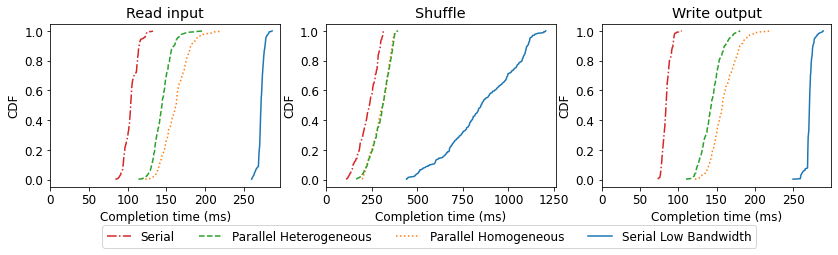

In [9]:
# Figure 12

ROOT_DIR = '../data/2.app/2.hadoop/'

subplot_id = 1
fig, axes = plt.subplots(1, 3, figsize=(14, 3))
for step in ['map-input', 'shuffle', 'reduce-output.same-assignment']:
    sub_dir = os.path.join(ROOT_DIR, "hadoop.sort.%s.K=1.100G" % step)
    result_hadoop_map_input(sub_dir, subplot_id, axes[subplot_id - 1])
    subplot_id += 1

ax = axes[1]
handles, labels = ax.get_legend_handles_labels()
# reorder homogeneous and heterogeneous
handles[0], handles[1], handles[2], handles[3] = handles[3], handles[2], handles[1], handles[0]
labels[0], labels[1], labels[2], labels[3] = labels[3], labels[2], labels[1], labels[0]
# plt.legend(handles, labels, ncol=1, loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(handles, labels, ncol=4, loc='upper center', bbox_to_anchor=(-0.75, -0.2))
# reorder_legend(ax, ['Serial low-bw', 'Parallel heterogeneous', 'Parallel homogeneous', 'Serial high-bw'])
plt.savefig('hadoop.fct.png', bbox_inches='tight')